<a href="https://colab.research.google.com/github/esinghbe23-ctrl/Date_Generation_using_Modelling_And_Simulation/blob/main/Topsis_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import cantera as ct
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [27]:
bounds = {
    "phi": (0.6, 1.4),
    "T0": (300, 1200),
    "P": (1e5, 5e5)
}

def random_samples(n):
    return np.column_stack([
        np.random.uniform(l, u, n)
        for l, u in bounds.values()
    ])

In [28]:
def cantera_sim(phi, T0, P):
    gas = ct.Solution("gri30.yaml")
    gas.set_equivalence_ratio(phi, "CH4:1", "O2:1, N2:3.76")
    gas.TP = T0, P
    gas.equilibrate("HP")
    return gas.T

In [30]:
X = random_samples(1000)
results = []

for phi, T0, P in X:
    try:
        Tflame = cantera_sim(phi, T0, P)
        results.append([phi, T0, P, Tflame])
    except:
        pass

df_sim = pd.DataFrame(results, columns=["phi", "T0", "P", "Flame_Temp"])
df_sim.to_csv("cantera_simulation_data.csv", index=True)

df_sim.head()

,phi,T0,P,Flame_Temp
0,0.609306,351.863503,352276.574378,1721.913110
1,1.062148,913.992946,188479.410492,2547.885809
2,0.962302,968.949386,428246.519350,2578.898125
3,1.079166,849.160926,327334.180884,2540.966839
4,1.292743,446.548633,122385.109826,2163.126232


In [31]:
X = df_sim[["phi","T0","P"]].values
y = df_sim["Flame_Temp"].values

idx = np.random.permutation(len(y))
split = int(0.8 * len(y))

X_train, X_test = X[idx[:split]], X[idx[split:]]
y_train, y_test = y[idx[:split]], y[idx[split:]]

In [32]:
def mse(y, yp):
    return np.mean((y-yp)**2)

def r2(y, yp):
    return 1 - np.sum((y-yp)**2) / np.sum((y-np.mean(y))**2)

In [33]:
def poly(X, d):
    return np.column_stack([X**i for i in range(1, d+1)])

# Degree 2
Xp2 = np.c_[np.ones(len(X_train)), poly(X_train,2)]
theta2 = np.linalg.inv(Xp2.T @ Xp2) @ Xp2.T @ y_train
y_poly2 = np.c_[np.ones(len(X_test)), poly(X_test,2)] @ theta2

# Degree 3
Xp3 = np.c_[np.ones(len(X_train)), poly(X_train,3)]
theta3 = np.linalg.inv(Xp3.T @ Xp3) @ Xp3.T @ y_train
y_poly3 = np.c_[np.ones(len(X_test)), poly(X_test,3)] @ theta3

In [34]:
def knn(Xtr, ytr, Xte, k=5):
    preds = []
    for x in Xte:
        d = np.linalg.norm(Xtr-x, axis=1)
        preds.append(np.mean(ytr[np.argsort(d)[:k]]))
    return np.array(preds)

y_knn = knn(X_train, y_train, X_test)

In [35]:
def nn_model(layers):
    model = Sequential()
    model.add(Dense(layers[0], activation="relu", input_shape=(3,)))
    for l in layers[1:]:
        model.add(Dense(l, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

architectures = {
    "NN_1": [16],
    "NN_2": [32,16],
    "NN_Deep": [64,32,16],
    "NN_Wide": [128]
}

nn_preds = {}

for name, arch in architectures.items():
    model = nn_model(arch)
    model.fit(X_train, y_train, epochs=50, verbose=0)
    nn_preds[name] = model.predict(X_test).flatten()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [36]:
rows = [
    ["Linear", mse(y_test,y_lr), r2(y_test,y_lr)],
    ["Poly2", mse(y_test,y_poly2), r2(y_test,y_poly2)],
    ["Poly3", mse(y_test,y_poly3), r2(y_test,y_poly3)],
    ["KNN", mse(y_test,y_knn), r2(y_test,y_knn)]
]

for name, pred in nn_preds.items():
    rows.append([name, mse(y_test,pred), r2(y_test,pred)])

df_models = pd.DataFrame(rows, columns=["Model","MSE","R2"])
df_models

,Model,MSE,R2
0,Linear,67261.199418,-0.638154
1,Poly2,634.118384,0.984556
2,Poly3,640.680463,0.984396
3,KNN,49332.165374,-0.201491
4,NN_1,675791.620473,-15.458984
5,NN_2,336172.597333,-7.187523
6,NN_Deep,614391.575835,-13.963578
7,NN_Wide,319832.989315,-6.789570


In [37]:
data = df_models[["MSE","R2"]].values
norm = data / np.sqrt((data**2).sum(axis=0))

weights = np.array([0.5, 0.5])
weighted = norm * weights

ideal = [weighted[:,0].min(), weighted[:,1].max()]
negative = [weighted[:,0].max(), weighted[:,1].min()]

d_pos = np.linalg.norm(weighted - ideal, axis=1)
d_neg = np.linalg.norm(weighted - negative, axis=1)

df_models["TOPSIS_Score"] = d_neg / (d_pos + d_neg)
df_models["Rank"] = df_models["TOPSIS_Score"].rank(ascending=False)

df_models.sort_values("Rank")

,Model,MSE,R2,TOPSIS_Score,Rank
1,Poly2,634.118384,0.984556,1.000000,1.0
2,Poly3,640.680463,0.984396,0.999990,2.0
3,KNN,49332.165374,-0.201491,0.927872,3.0
0,Linear,67261.199418,-0.638154,0.901316,4.0
7,NN_Wide,319832.989315,-6.789570,0.527223,5.0
5,NN_2,336172.597333,-7.187523,0.503022,6.0
6,NN_Deep,614391.575835,-13.963578,0.090942,7.0
4,NN_1,675791.620473,-15.458984,0.000000,8.0


In [38]:
df_models.sort_values("Rank").to_csv("topsis_model_ranking.csv", index=False)

In [39]:
Topsis_Ranking=pd.read_csv('topsis_model_ranking.csv')
print(Topsis_Ranking)

     Model            MSE         R2  TOPSIS_Score  Rank
0    Poly2     634.118384   0.984556      1.000000   1.0
1    Poly3     640.680463   0.984396      0.999990   2.0
2      KNN   49332.165374  -0.201491      0.927872   3.0
3   Linear   67261.199418  -0.638154      0.901316   4.0
4  NN_Wide  319832.989315  -6.789570      0.527223   5.0
5     NN_2  336172.597333  -7.187523      0.503022   6.0
6  NN_Deep  614391.575835 -13.963578      0.090942   7.0
7     NN_1  675791.620473 -15.458984      0.000000   8.0


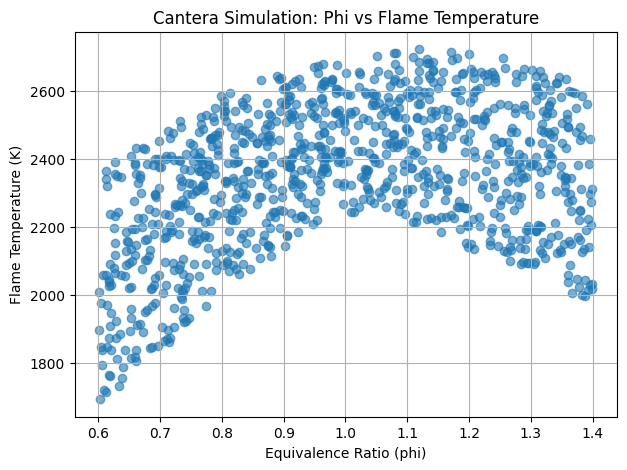

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,5))
plt.scatter(df_sim["phi"], df_sim["Flame_Temp"], alpha=0.6)
plt.xlabel("Equivalence Ratio (phi)")
plt.ylabel("Flame Temperature (K)")
plt.title("Cantera Simulation: Phi vs Flame Temperature")
plt.grid(True)
plt.show()

/tmp/ipython-input-2251794612.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="MSE", data=df_models, palette="viridis")


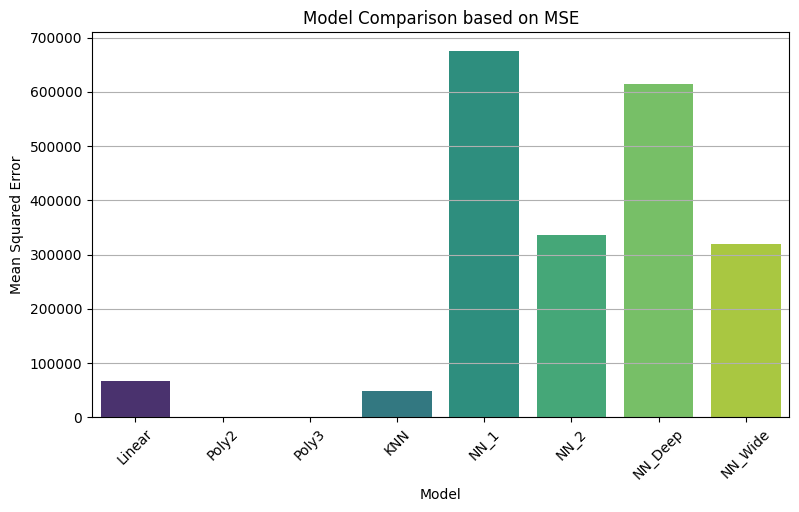

In [41]:
plt.figure(figsize=(9,5))
sns.barplot(x="Model", y="MSE", data=df_models, palette="viridis")
plt.xticks(rotation=45)
plt.title("Model Comparison based on MSE")
plt.ylabel("Mean Squared Error")
plt.grid(axis="y")
plt.show()

/tmp/ipython-input-500729263.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2", data=df_models, palette="coolwarm")


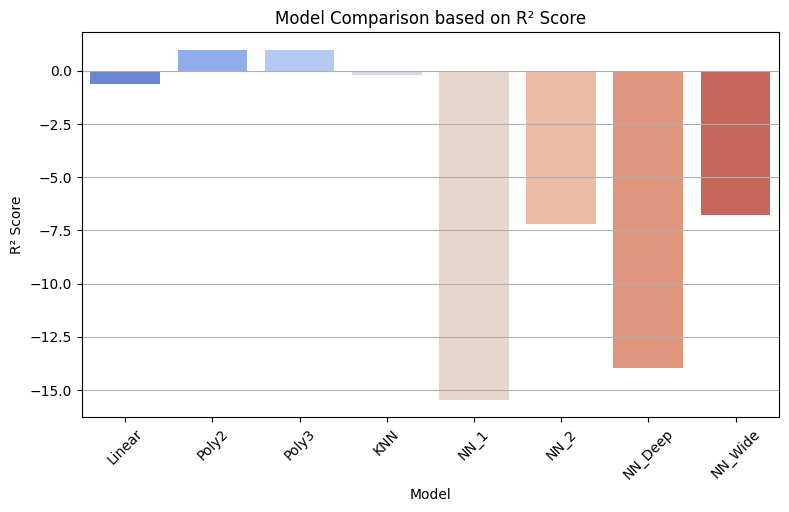

In [42]:
plt.figure(figsize=(9,5))
sns.barplot(x="Model", y="R2", data=df_models, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Model Comparison based on R² Score")
plt.ylabel("R² Score")
plt.grid(axis="y")
plt.show()

/tmp/ipython-input-4074851737.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


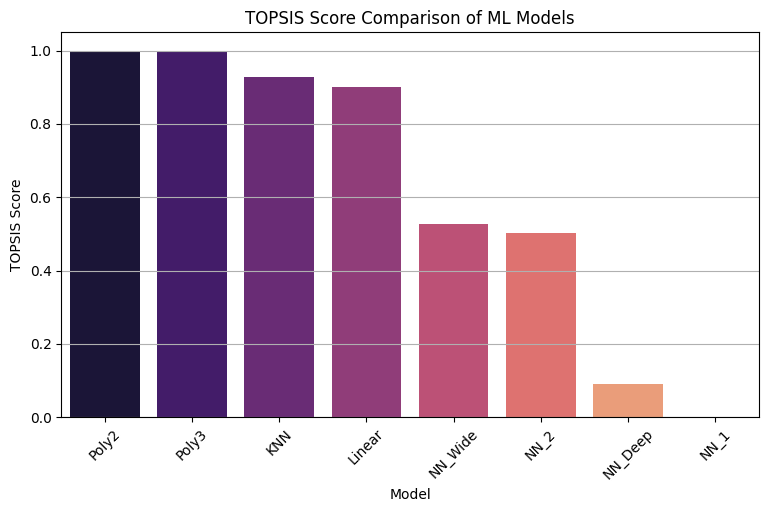

In [43]:
plt.figure(figsize=(9,5))
sns.barplot(
    x="Model",
    y="TOPSIS_Score",
    data=df_models.sort_values("TOPSIS_Score", ascending=False),
    palette="magma"
)

plt.xticks(rotation=45)
plt.title("TOPSIS Score Comparison of ML Models")
plt.ylabel("TOPSIS Score")
plt.grid(axis="y")
plt.show()

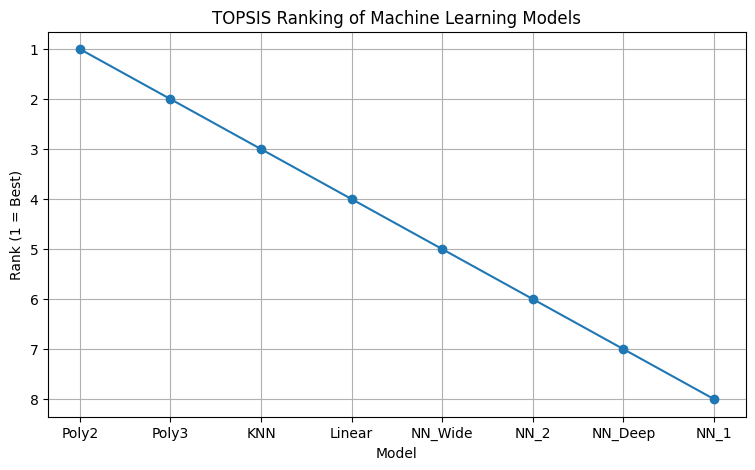

In [44]:
plt.figure(figsize=(9,5))
plt.plot(
    df_models.sort_values("Rank")["Model"],
    df_models.sort_values("Rank")["Rank"],
    marker='o'
)

plt.gca().invert_yaxis()
plt.title("TOPSIS Ranking of Machine Learning Models")
plt.xlabel("Model")
plt.ylabel("Rank (1 = Best)")
plt.grid(True)
plt.show()

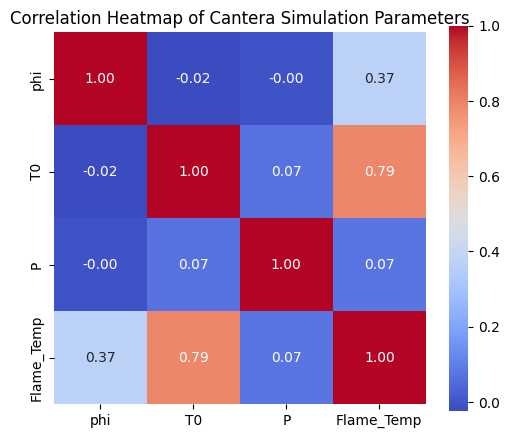

In [45]:
plt.figure(figsize=(6,5))
corr = df_sim.corr()

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True
)

plt.title("Correlation Heatmap of Cantera Simulation Parameters")
plt.show()

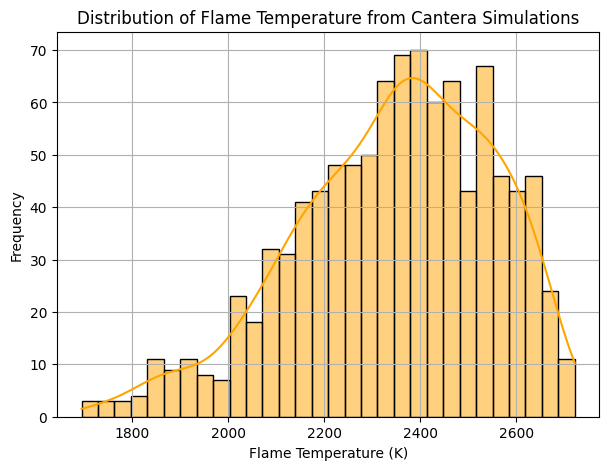

In [46]:
plt.figure(figsize=(7,5))
sns.histplot(df_sim["Flame_Temp"], bins=30, kde=True, color="orange")

plt.xlabel("Flame Temperature (K)")
plt.ylabel("Frequency")
plt.title("Distribution of Flame Temperature from Cantera Simulations")
plt.grid(True)
plt.show()

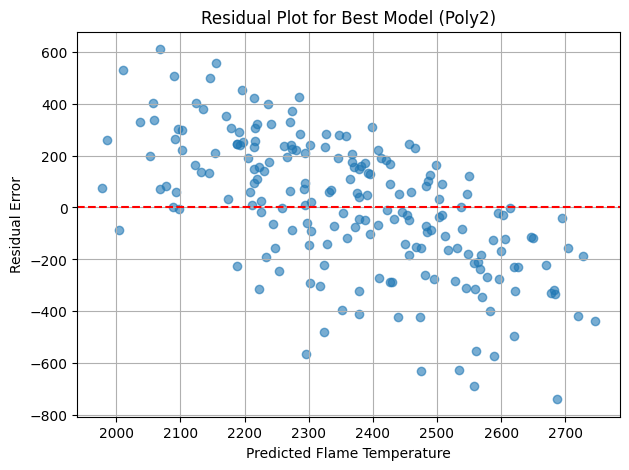

In [47]:
best_model = df_models.sort_values("Rank").iloc[0]["Model"]

# choose prediction source
if best_model in nn_preds:
    y_pred_best = nn_preds[best_model]
else:
    y_pred_best = y_lr  # fallback

residuals = y_test - y_pred_best

plt.figure(figsize=(7,5))
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')

plt.xlabel("Predicted Flame Temperature")
plt.ylabel("Residual Error")
plt.title(f"Residual Plot for Best Model ({best_model})")
plt.grid(True)
plt.show()

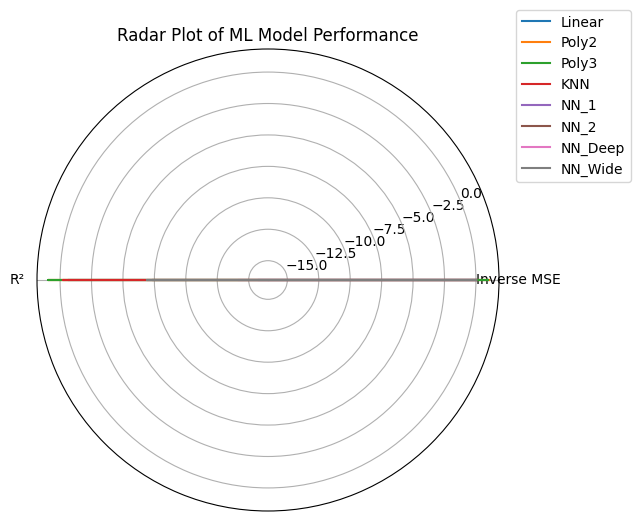

In [48]:
from math import pi

models = df_models["Model"].values
mse_norm = 1 / df_models["MSE"].values   # lower is better
r2_norm = df_models["R2"].values

metrics = np.column_stack([mse_norm, r2_norm])
metrics = metrics / metrics.max(axis=0)

angles = np.linspace(0, 2*pi, 2, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

for i, model in enumerate(models):
    values = metrics[i].tolist()
    values += values[:1]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(["Inverse MSE", "R²"])
plt.title("Radar Plot of ML Model Performance")
plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
plt.show()